In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [7]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [11]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [6]:
data_classification.head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,installment,zip_code,revol_util,fico_range_low,total_rev_hi_lim,revol_bal,bc_util,avg_cur_bal,credit_history_years,loan_status
0,744.0,126.0,0.0917,50000.0,4.66,140.27,622.0,0.768,710.0,7700.0,5913.0,76.8,64898.0,11,0
1,739.0,151.0,0.1249,60000.0,16.14,568.64,800.0,0.865,685.0,27700.0,23949.0,87.1,1831.0,12,0
2,614.0,292.0,0.0819,75000.0,24.67,244.41,350.0,0.858,680.0,20300.0,17425.0,96.3,19333.0,24,0
3,604.0,206.0,0.2449,67500.0,15.81,492.45,301.0,0.396,675.0,53300.0,21088.0,39.4,6661.0,17,1
4,654.0,424.0,0.1199,70000.0,23.70,332.10,770.0,0.847,660.0,22725.0,19249.0,94.9,25393.0,36,0


In [12]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

In [13]:
train_classification = pd.concat([X_train, y_train], axis=1)

## CTGAN 적용

In [9]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train_label_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

In [11]:
label1_data.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'installment', 'zip_code', 'revol_util',
       'fico_range_low', 'total_rev_hi_lim', 'revol_bal', 'bc_util',
       'avg_cur_bal', 'total_il_high_credit_limit', 'grade', 'total_pymnt',
       'total_pymnt_inv', 'loan_amnt', 'credit_history_years', 'term_months',
       'loan_status'],
      dtype='object')

In [12]:
import pandas as pd
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
import torch
import os


N_CLS_PER_GEN = 550_000
OUTPUT_PATH = 'synthetic_ctgan_data_class1.csv'


discrete_columns = ['zip_code', 'grade', 'term_months', 'loan_status']

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=label1_data)

for column in discrete_columns:
    metadata.update_column(column_name=column, sdtype='categorical')

synthesizer = CTGANSynthesizer(
    metadata,
    epochs=500,
    cuda=torch.cuda.is_available(),  # CUDA 사용 여부
    verbose=True
)

print("🧪 Start training CTGAN on class 1 data...")
synthesizer.fit(label1_data)
print("✅ Training completed.")

print(f"🔄 Sampling {N_CLS_PER_GEN} synthetic samples...")
synthetic_data = synthesizer.sample(num_rows=N_CLS_PER_GEN)

os.makedirs("ctgan_output", exist_ok=True)
output_file = os.path.join("ctgan_output", OUTPUT_PATH)
synthetic_data.to_csv(output_file, index=False)
print(f"✅ Synthetic data saved to: {output_file}")

🧪 Start training CTGAN on class 1 data...
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name       Est # of Columns (CTGAN)
last_fico_range_high       11
mo_sin_old_rev_tl_op       11
int_rate                   11
annual_inc                 11
dti                        11
installment                11
zip_code                   890
revol_util                 11
fico_range_low             11
total_rev_hi_lim           11
revol_bal                  11
bc_util                    11
avg_cur_bal                11
total_il_high_credit_limit 11
grade                      7
total_pymnt                11
total_pymnt_inv            11
loan_amnt                  11
credit_history_years       11
term_months                2
loan_status                1

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that ar

Gen. (-0.06) | Discrim. (0.18): 100%|██████████| 500/500 [2:56:35<00:00, 21.19s/it]   


✅ Training completed.
🔄 Sampling 550000 synthetic samples...
✅ Synthetic data saved to: ctgan_output\synthetic_ctgan_data_class1.csv


## CTGAN 학습

In [ ]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

## Load original data
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/CTGAN/ctgan_output/synthetic_ctgan_data_class1.csv"
fake = pd.read_csv(fake_path, low_memory=False)

In [ ]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [ ]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [ ]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

loan_status
1    724231
0    718935
Name: count, dtype: int64

In [18]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68670	validation_1-logloss:0.68905
[1]	validation_0-logloss:0.68038	validation_1-logloss:0.68285
[2]	validation_0-logloss:0.67419	validation_1-logloss:0.67675
[3]	validation_0-logloss:0.66812	validation_1-logloss:0.67078
[4]	validation_0-logloss:0.66217	validation_1-logloss:0.66494
[5]	validation_0-logloss:0.65633	validation_1-logloss:0.65921
[6]	validation_0-logloss:0.65060	validation_1-logloss:0.65359
[7]	validation_0-logloss:0.64497	validation_1-logloss:0.64805
[8]	validation_0-logloss:0.63946	validation_1-logloss:0.64265
[9]	validation_0-logloss:0.63404	validation_1-logloss:0.63734
[10]	validation_0-logloss:0.62873	validation_1-logloss:0.63214
[11]	validation_0-logloss:0.62351	validation_1-logloss:0.62702
[12]	validation_0-logloss:0.61839	validation_1-logloss:0.62201
[13]	validation_0-logloss:0.61336	validation_1-logloss:0.61708
[14]	validation_0-logloss:0.60842	validation_1-logloss:0.61225
[15]	validation_0-logloss:0.60358	validation_1-logloss:0.60752
[1

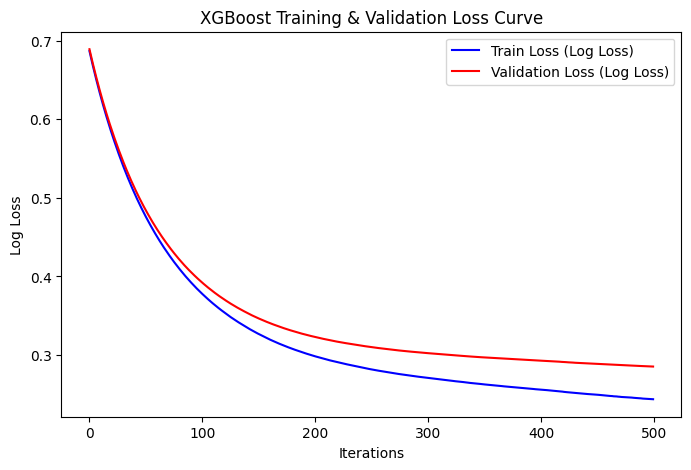

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92    599114
           1       0.62      0.89      0.73    145192

    accuracy                           0.87    744306
   macro avg       0.79      0.88      0.82    744306
weighted avg       0.90      0.87      0.88    744306



In [20]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.43
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [21]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[520157  78957]
 [ 16460 128732]]

True Positives (TP): 128732
False Positives (FP): 78957
True Negatives (TN): 520157
False Negatives (FN): 16460
